In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

100%|██████████| 170M/170M [00:05<00:00, 29.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
dataiter = iter(data_loader)
images, labels = next(dataiter)  # Use next(dataiter) instead of dataiter.next()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [19]:
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(32 * 32 * 3, 128),  # Changed input size to 32 * 32 * 3
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 32 * 32 * 3),  # Changed output size to 32 * 32 * 3
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )


        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [20]:
model_linear = Autoencoder_Linear()
criterion_linear = nn.MSELoss()
optimizer_linear = torch.optim.Adam(model_linear.parameters(), lr=1e-3, weight_decay=1e-5)

outputs_linear = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.view(img.size(0), -1)
        recon = model_linear(img)
        loss = criterion_linear(recon, img)

        optimizer_linear.zero_grad()
        loss.backward()
        optimizer_linear.step()
    # The print statement should be indented to match the outer for loop.
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs_linear.append((epoch, img, recon))

Epoch:1, Loss:0.0337


In [9]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)

In [11]:
num_epochs = 1
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:

        img = img.mean(dim=1, keepdim=True)

        recon = model(img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0066


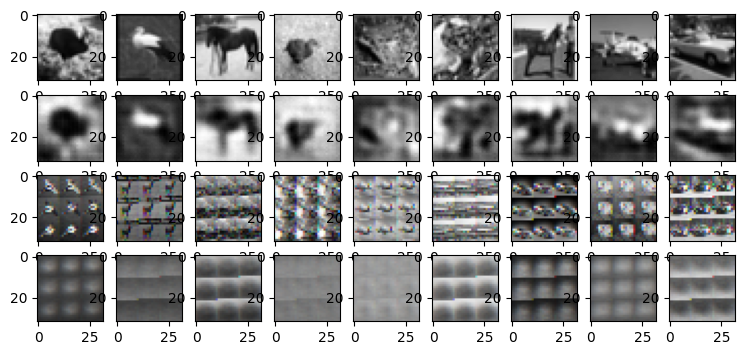

In [24]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 4)) # Increased figure height
    plt.gray()

    # Convolutional Autoencoder Output
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(4, 9, i+1)  # Adjusted subplot grid
        plt.imshow(item[0])
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(4, 9, 9+i+1) # Adjusted subplot grid
        plt.imshow(item[0])

    # Linear Autoencoder Output
    imgs_linear = outputs_linear[k][1].detach().numpy()
    recon_linear = outputs_linear[k][2].detach().numpy()
    for i, item in enumerate(imgs_linear):
        if i >= 9: break
        plt.subplot(4, 9, 18+i+1)  # Adjusted subplot grid
        # Changed to 32, 32, 3 to match the shape before flattening in model
        item = item.reshape(32, 32, 3)
        plt.imshow(item)
    for i, item in enumerate(recon_linear):
        if i >= 9: break
        plt.subplot(4, 9, 27+i+1)  # Adjusted subplot grid
        # Changed to 32, 32, 3 to match the shape before flattening in model
        item = item.reshape(32, 32, 3)
        plt.imshow(item)

    plt.show()